In [1]:
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

seed = 42
AMOUNT_OF_FRAMES = 120
BLENDNAMES = ['_neutral', 'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft', 'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight', 'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight', 'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen', 'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight', 'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft', 'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft', 'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower', 'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft', 'mouthUpperUpRight', 'noseSneerLeft', 'noseSneerRight']

In [2]:
path2data = "/project_ghent/Master-Thesis/featureExtraction/output_blendshape_split"
SKIP_FRAMES = 1

important_blendshapes = [8, 17, 18, 26, 28, 33, 43]
ids, labels, groups, catgs = utils.get_vids(path2data)
utils.split_dataset(ids, labels, groups, skipframes=SKIP_FRAMES, name="big_important", important=important_blendshapes)

Name		 ids labels groups
--------------------------------------
Train_val: 	 6780 6780 31
Test: 		 740 740 4
Train: 		 5069 5069 23
Validation: 	 1711 1711 8
--------------------------------------
Name distribution:	 YES - NO
Original distribution:	 0.7253989361702128 - 0.2746010638297872
Train distribution:	 0.7119747484710989 - 0.2880252515289012
Val distribution:	 0.7375803623611923 - 0.2624196376388077
Test distribution:	 0.7891891891891892 - 0.21081081081081082
--------------------------------------
Succesfully saved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 1 [big_important]


In [3]:
SKIP_FRAMES = 1
train_ds, val_ds, test_ds = utils.get_dataset(skipframes=SKIP_FRAMES, name="big_important")

Succesfully retrieved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 1 [big_important]


In [4]:
len(train_ds[0][0][0]), len(train_ds[0][0])

(7, 120)

# Test out simple model

In [5]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        x = x.sum(dim=1)
        return self.linear(x)

Succesfully retrieved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 1 [big_important]
Training...


Epoch 100/100: 100%|██████████| 634/634 [00:22<00:00, 28.22batch/s, Loss=0.515]


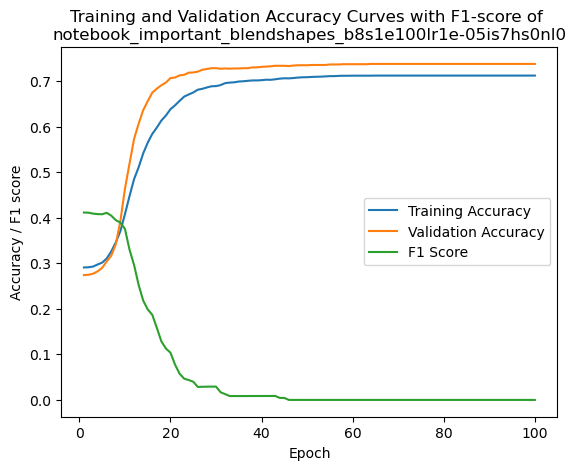

Plotting confusion matrix...


<Figure size 640x480 with 0 Axes>

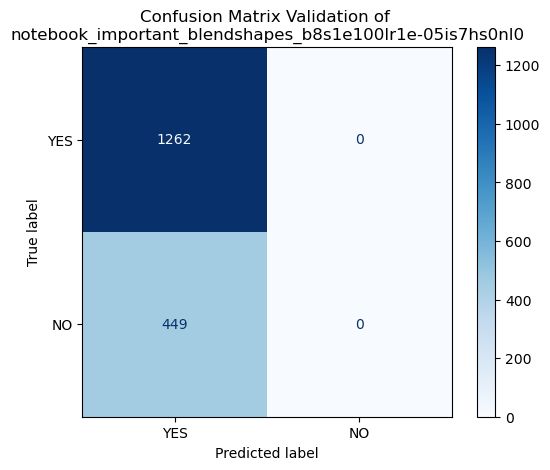

Plotting ROC curve...


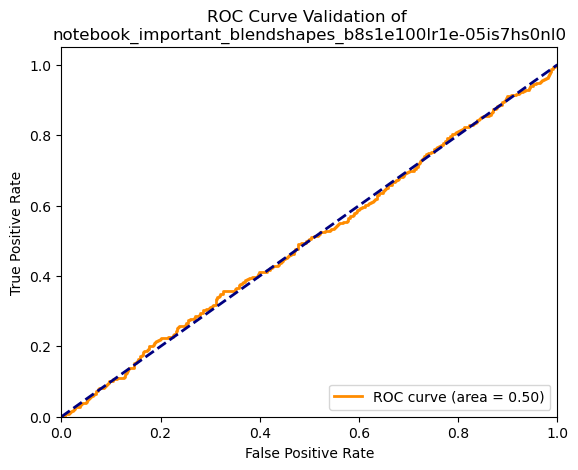

Saving model...


In [6]:
important_blendshapes = [8, 17, 18, 26, 28, 33, 43]

batch_size = 8
skipframes = 1
num_epochs = 100
lr = 1e-5
num_workers = 4
pos_weight = 0.378
INPUT_SIZE = len(important_blendshapes)
HIDDEN_SIZE = 0
NUM_LAYERS = 0
name_dataset = "big_important"

name = f"notebook_important_blendshapes_b{batch_size}s{skipframes}e{num_epochs}lr{lr}is{INPUT_SIZE}hs{HIDDEN_SIZE}nl{NUM_LAYERS}"

train_ds, val_ds, test_ds = utils.get_dataset(skipframes=skipframes, name=name_dataset)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed), num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size=2*batch_size, shuffle=False, num_workers=num_workers)  
test_dl = DataLoader(test_ds, batch_size=2*batch_size, shuffle=False, num_workers=num_workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LogisticRegressionModel(INPUT_SIZE).to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=torch.tensor([pos_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=lr)

parameters = {"device": device, 
              "epochs": num_epochs,
              "trainloader": train_dl,
              "valloader": val_dl,
              "testloader": test_dl,
              "criterion": criterion,
              "optimizer": optimizer,
              "batch_size": batch_size,
              "amount_of_frames": AMOUNT_OF_FRAMES // skipframes,
              "categories":  utils.categories.keys(),
              "decision": 0.5}

print("Training...")

utils.train_and_plot(model, parameters, name)

print("Plotting confusion matrix...")

utils.plot_confusionmatrix(model, parameters, name, mode="Validation", verbose=False)

print("Plotting ROC curve...")

utils.plot_roc_curve(model, parameters, name, mode="Validation", verbose=False)

print("Saving model...")

torch.save(model, f"/project_ghent/Master-Thesis/ownModelNotebooks/models/blendshape_{name}.pth")